In [ ]:
import os
import glob
import numpy as np

import io
from PIL import Image
from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred



class CreateModel:

    def __init__(self, train_img_path, img_width=200, img_height=50):
        # 이미지 크기
        self.img_width = img_width
        self.img_height = img_height
        # 학습 이미지 파일 경로 리스트
        self.images = sorted(train_img_path)
        # 학습 이미지 파일 라벨 리스트
        self.labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in self.images]
        # 라벨 SET
        self.characters = set(char for label in self.labels for char in label)
        # 라벨 최대 길이
        self.max_length = max([len(label) for label in self.labels])

        # Mapping characters to integers
        self.char_to_num = layers.experimental.preprocessing.StringLookup(
            vocabulary=sorted(self.characters), num_oov_indices=0, mask_token=None
        )
        # Mapping integers back to original characters
        self.num_to_char = layers.experimental.preprocessing.StringLookup(
            vocabulary=self.char_to_num.get_vocabulary(), mask_token=None, invert=True
        )

    def __init__(self, train_img_path, train_label_path, img_width=200, img_height=50):
        # 이미지 크기
        self.img_width = img_width
        self.img_height = img_height
        # 학습 이미지 파일 경로 리스트
        self.images = sorted(train_img_path)

        self.label_paths = sorted(train_label_path)

        # 학습 이미지 파일 라벨 리스트
        # self.labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in self.images]
        self.labels = self.load_labels(self.label_paths)
        # 라벨 SET
        self.characters = set(char for label in self.labels for char in label)
        # 라벨 최대 길이
        self.max_length = max([len(label) for label in self.labels])

        # Mapping characters to integers
        self.char_to_num = layers.experimental.preprocessing.StringLookup(
            vocabulary=sorted(self.characters), num_oov_indices=0, mask_token=None
        )
        # Mapping integers back to original characters
        self.num_to_char = layers.experimental.preprocessing.StringLookup(
            vocabulary=self.char_to_num.get_vocabulary(), mask_token=None, invert=True
        )

    def load_labels(self, label_paths):
        labels = []
        for label in label_paths:
          with open(label, 'r') as f:
            labels.append(f.readline().rjust(5, ' '))

        return labels


    def train_model(self, epochs=100, earlystopping=False):
        # 학습 및 검증을 위한 배치 사이즈 정의
        batch_size = 16
        # 다운 샘플링 요인 수 (Conv: 2, Pooling: 2)
        downsample_factor = 4

        # Splitting data into training and validation sets
        x_train, x_valid, y_train, y_valid = self.split_data(np.array(self.images), np.array(self.labels))

        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
        train_dataset = (
            train_dataset.map(
                self.encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
            )
            .batch(batch_size)
            .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        )

        validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
        validation_dataset = (
            validation_dataset.map(
                self.encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
            )
            .batch(batch_size)
            .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        )

        # Get the model
        model = self.build_model()

        if earlystopping == True:

            early_stopping_patience = 10
            # Add early stopping
            early_stopping = keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
            )

            # Train the model
            history = model.fit(
                train_dataset,
                validation_data=validation_dataset,
                epochs=epochs,
                callbacks=[early_stopping],
            )

        else:
            # Train the model
            history = model.fit(
                train_dataset,
                validation_data=validation_dataset,
                epochs=epochs
            )


        return model


    def encode_single_sample(self, img_path, label):
        # 1. Read image
        img = tf.io.read_file(img_path)
        # 2. Decode and convert to grayscale
        img = tf.io.decode_png(img, channels=1)
        # 3. Convert to float32 in [0, 1] range
        img = tf.image.convert_image_dtype(img, tf.float32)
        # 4. Resize to the desired size
        img = tf.image.resize(img, [self.img_height, self.img_width])
        # 5. Transpose the image because we want the time
        # dimension to correspond to the width of the image.
        img = tf.transpose(img, perm=[1, 0, 2])
        # 6. Map the characters in label to numbers
        label = self.char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
        # 7. Return a dict as our model is expecting two inputs
        return {"image": img, "label": label}

    def build_model(self):
        # Inputs to the model
        input_img = layers.Input(
            shape=(self.img_width, self.img_height, 1), name="image", dtype="float32"
        )
        labels = layers.Input(name="label", shape=(None,), dtype="float32")

        # First conv block
        x = layers.Conv2D(
            32,
            (3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            padding="same",
            name="Conv1",
        )(input_img)
        x = layers.MaxPooling2D((2, 2), name="pool1")(x)

        # Second conv block
        x = layers.Conv2D(
            64,
            (3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            padding="same",
            name="Conv2",
        )(x)
        x = layers.MaxPooling2D((2, 2), name="pool2")(x)

        # We have used two max pool with pool size and strides 2.
        # Hence, downsampled feature maps are 4x smaller. The number of
        # filters in the last layer is 64. Reshape accordingly before
        # passing the output to the RNN part of the model
        new_shape = ((self.img_width // 4), (self.img_height // 4) * 64)
        x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
        x = layers.Dense(64, activation="relu", name="dense1")(x)
        x = layers.Dropout(0.2)(x)

        # RNNs
        x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
        x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

        # Output layer
        x = layers.Dense(len(self.characters) + 1, activation="softmax", name="dense2")(x)

        # Add CTC layer for calculating CTC loss at each step
        output = CTCLayer(name="ctc_loss")(labels, x)

        # Define the model
        model = keras.models.Model(
            inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
        )
        # Optimizer
        opt = keras.optimizers.Adam()
        # Compile the model and return
        model.compile(optimizer=opt)
        return model

    def split_data(self, images, labels, train_size=0.9, shuffle=True):
        # 1. Get the total size of the dataset
        size = len(images)
        # 2. Make an indices array and shuffle it, if required
        indices = np.arange(size)
        if shuffle:
            np.random.shuffle(indices)
        # 3. Get the size of training samples
        train_samples = int(size * train_size)
        # 4. Split data into training and validation sets
        x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
        x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
        return x_train, x_valid, y_train, y_valid


class ApplyModel:

    def __init__(self,
                 weights_path,
                 img_width=200,
                 img_height=50,
                 max_length=6,
                 characters={'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}):

        self.img_width = img_width
        self.img_height = img_height
        self.max_length = max_length
        self.characters = characters

        # Mapping characters to integers
        self.char_to_num = layers.experimental.preprocessing.StringLookup(
            vocabulary=sorted(self.characters), num_oov_indices=0, mask_token=None
        )
        # Mapping integers back to original characters
        self.num_to_char = layers.experimental.preprocessing.StringLookup(
            vocabulary=self.char_to_num.get_vocabulary(), mask_token=None, invert=True
        )
        # Model
        self.model = self.build_model()
        self.model.load_weights(weights_path)
        self.prediction_model = keras.models.Model(
            self.model.get_layer(name="image").input, self.model.get_layer(name="dense2").output
        )

    def predict(self, target_img_path):
        target_img = self.encode_single_sample(target_img_path)['image']
        target_img = tf.reshape(target_img, shape=[1,self.img_width,self.img_height,1])
        pred_val = self.prediction_model.predict(target_img)
        pred = self.decode_batch_predictions(pred_val)[0]
        return pred

    def predict_from_bytes(self, image_bytes):
        target_img = self.encode_single_sample_from_bytes(image_bytes)['image']
        target_img = tf.expand_dims(target_img, 0)
        pred_val = self.prediction_model.predict(target_img)
        pred = self.decode_batch_predictions(pred_val)[0]
        return pred

    def encode_single_sample(self, img_path):
        img = tf.io.read_file(img_path)
        img = tf.io.decode_png(img, channels=1)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, [self.img_height, self.img_width])
        img = tf.transpose(img, perm=[1, 0, 2])
        return {"image": img}

    def encode_single_sample_from_bytes(self, image_bytes):
        img = tf.io.decode_image(image_bytes, channels=1)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, [self.img_height, self.img_width])
        img = tf.transpose(img, perm=[1, 0, 2])
        return {"image": img}

    def build_model(self):
        # Inputs to the model
        input_img = layers.Input(
            shape=(self.img_width, self.img_height, 1), name="image", dtype="float32"
        )
        labels = layers.Input(name="label", shape=(None,), dtype="float32")

        # First conv block
        x = layers.Conv2D(
            32,
            (3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            padding="same",
            name="Conv1",
        )(input_img)
        x = layers.MaxPooling2D((2, 2), name="pool1")(x)

        # Second conv block
        x = layers.Conv2D(
            64,
            (3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            padding="same",
            name="Conv2",
        )(x)
        x = layers.MaxPooling2D((2, 2), name="pool2")(x)

        # We have used two max pool with pool size and strides 2.
        # Hence, downsampled feature maps are 4x smaller. The number of
        # filters in the last layer is 64. Reshape accordingly before
        # passing the output to the RNN part of the model
        new_shape = ((self.img_width // 4), (self.img_height // 4) * 64)
        x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
        x = layers.Dense(64, activation="relu", name="dense1")(x)
        x = layers.Dropout(0.2)(x)

        # RNNs
        x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
        x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

        # Output layer
        x = layers.Dense(len(self.characters) + 1, activation="softmax", name="dense2")(x)

        # Add CTC layer for calculating CTC loss at each step
        output = CTCLayer(name="ctc_loss")(labels, x)

        # Define the model
        model = keras.models.Model(
            inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
        )
        # Optimizer
        opt = keras.optimizers.Adam()
        # Compile the model and return
        model.compile(optimizer=opt)
        return model

    def split_data(self, images, labels, train_size=0.9, shuffle=True):
        # 1. Get the total size of the dataset
        size = len(images)
        # 2. Make an indices array and shuffle it, if required
        indices = np.arange(size)
        if shuffle:
            np.random.shuffle(indices)
        # 3. Get the size of training samples
        train_samples = int(size * train_size)
        # 4. Split data into training and validation sets
        x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
        x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
        return x_train, x_valid, y_train, y_valid


    # A utility function to decode the output of the network
    def decode_batch_predictions(self, pred):
        input_len = np.ones(pred.shape[0]) * pred.shape[1]
        # Use greedy search. For complex tasks, you can use beam search
        results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
            :, :self.max_length
        ]
        # Iterate over the results and get back the text
        output_text = []
        for res in results:
            res = tf.strings.reduce_join(self.num_to_char(res+1)).numpy().decode("utf-8")
            output_text.append(res)
        return output_text

# prepare the data

In [ ]:
!cp drive/MyDrive/captcha/preped_captcha_dataset.tar.gz .

In [ ]:
!tar -xf preped_captcha_dataset.tar.gz

In [ ]:
!ls captchas | wc -l

5000


In [ ]:
!cp drive/MyDrive/captcha/preped_captcha_test_dataset.tar.gz .

In [ ]:
!tar -xf preped_captcha_test_dataset.tar.gz

## the model

In [ ]:
import glob

# Training image data path
train_img_path_list = glob.glob("./captchas/*.png")
# Training label data path
train_label_path_list = glob.glob('./labels/*.txt')

# Training image data size
img_width = 180
img_height = 50

# Creating an instance that creates a model
CM = CreateModel(train_img_path_list, train_label_path_list, img_width, img_height)

# Performing model training
model = CM.train_model(epochs=20)

# Saving the weights learned by the model to a file
model.save_weights("./model/weights.h5")

Epoch 1/20
282/282 [==============================] - 32s 41ms/step - loss: 10.9721 - val_loss: 8.9480
Epoch 2/20
282/282 [==============================] - 9s 30ms/step - loss: 8.7178 - val_loss: 8.3509
Epoch 3/20
282/282 [==============================] - 9s 33ms/step - loss: 7.2366 - val_loss: 5.8174
Epoch 4/20
282/282 [==============================] - 9s 32ms/step - loss: 5.1197 - val_loss: 4.3246
Epoch 5/20
282/282 [==============================] - 8s 27ms/step - loss: 3.9045 - val_loss: 3.1020
Epoch 6/20
282/282 [==============================] - 9s 32ms/step - loss: 3.0412 - val_loss: 2.6331
Epoch 7/20
282/282 [==============================] - 8s 29ms/step - loss: 2.3407 - val_loss: 1.7755
Epoch 8/20
282/282 [==============================] - 8s 30ms/step - loss: 1.6887 - val_loss: 1.2152
Epoch 9/20
282/282 [==============================] - 9s 32ms/step - loss: 1.2357 - val_loss: 0.8428
Epoch 10/20
282/282 [==============================] - 9s 32ms/step - loss: 0.9040 - val_

## predict

In [ ]:
# Target image data size
img_width = 180
img_height = 50
# Target image label length
max_length = 5
# Target image label component
characters = {' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-'}

# Model weight file path
weights_path = "./model/weights.h5"
# Creating a model application instance
AM = ApplyModel(weights_path, img_width, img_height, max_length, characters)

In [ ]:
# Target image path
target_img_path = "./captchas/2.png"

# Predicted value
pred = AM.predict(target_img_path)
print(pred)

1/1 [==============================] - 0s 35ms/step
 7+13


In [ ]:
import os

detected = 0
wrong = []

# Test image data path
test_img_path_list = sorted(glob.glob("./test_captchas/*.png"))
# Test label data path
test_label_path_list = sorted(glob.glob('./test_labels/*.txt'))

for i, captcha_name in enumerate(test_img_path_list):
  label_name = captcha_name.replace('captchas', 'labels').replace('png', 'txt')

  with open(label_name, 'r') as f:
    ans = f.readline()

  pred = AM.predict(captcha_name)

  if ans.strip() == pred.strip():
    print(ans)
    print(pred)
    detected += 1
  else:
    wrong.append((captcha_name, pred, ans))

  if i > 100: break


1/1 [==============================] - 0s 52ms/step
13+8
 13+8
1/1 [==============================] - 0s 40ms/step
16-8
 16-8
1/1 [==============================] - 0s 34ms/step
14-6
 14-6
1/1 [==============================] - 0s 40ms/step
7+18
 7+18
1/1 [==============================] - 0s 53ms/step
1+13
 1+13
1/1 [==============================] - 0s 52ms/step
11-6
 11-6
1/1 [==============================] - 0s 102ms/step
17-2
 17-2
1/1 [==============================] - 0s 120ms/step
4+10
 4+10
1/1 [==============================] - 0s 106ms/step
4+10
 4+10
1/1 [==============================] - 0s 107ms/step
5+17
 5+17
1/1 [==============================] - 0s 124ms/step
3+16
 3+16
1/1 [==============================] - 0s 76ms/step
9+5
  9+5
1/1 [==============================] - 0s 108ms/step
19+4
 19+4
1/1 [==============================] - 0s 66ms/step
17+4
 17+4
1/1 [==============================] - 0s 75ms/step
13-8
 13-8
1/1 [==============================] - 0s 74ms/ste

In [ ]:
print(f"accuracy: {detected/len(test_img_path_list)*100}%")

accuracy: 96.0%


In [ ]:
!cp model/weights.h5 drive/MyDrive/checkpoints/final/weights.h5

In [ ]:
wrong

[('./test_captchas/5012.png', '  6+5', '6+8'),
 ('./test_captchas/5044.png', ' 19-3', '18-3')]

# preprocessing functions

In [ ]:
import cv2

In [ ]:
def remove_noise(img):
  kernel_size = 3
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
  closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

  # Apply binary thresholding with a threshold value of 127
  threshold_value = 190
  max_value = 255
  ret, thresholded_img = cv2.threshold(closing, threshold_value, max_value, cv2.THRESH_BINARY)

  kernel_size = 3
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
  dilation = cv2.morphologyEx(thresholded_img, cv2.MORPH_DILATE, kernel)
  return dilation

In [ ]:
def process(img_path, new_img_path='tmp.png'):
  img = cv2.imread(img_path, 0)
  final = remove_noise(img)
  cv2.imwrite(new_img_path, final)

# final prediction function

In [ ]:
!cp drive/MyDrive/captcha/medium-captcha-2.tar.gz .

In [ ]:
!tar -xf medium-captcha-2.tar.gz

In [ ]:
def predict(captcha_path):

  temp_captcha_path = './tmp.png'
  process(captcha_path, temp_captcha_path)

  pred = AM.predict(temp_captcha_path).strip()
  output = eval(pred)

  os.remove(temp_captcha_path)
  return output

In [ ]:
predict('./captcha/5005.png')

1/1 [==============================] - 0s 32ms/step


14

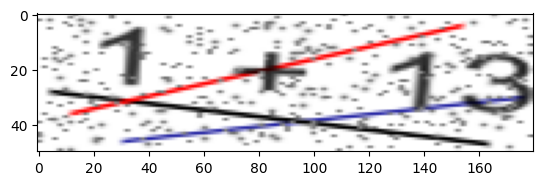

In [ ]:
import matplotlib.pyplot as plt

img = cv2.imread('./captcha/5005.png')

plt.imshow(img, cmap='gray')